In [1]:
import os
os.chdir('../')
from python_code import gibbs_sampler as gs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
from itertools import combinations
import pymc3 as pm
from scipy.stats import norm

In [48]:
df = pd.read_csv('../data/mathtest.csv')
df.columns = ['group', 'values']

In [58]:
gibbs = gs.GibbsSampler(df, n_iter=5000, burn=100, mu=df['values'].mean(), theta=df.groupby('group').mean()['values'].to_numpy())



In [59]:
gibbs.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1001.37it/s]


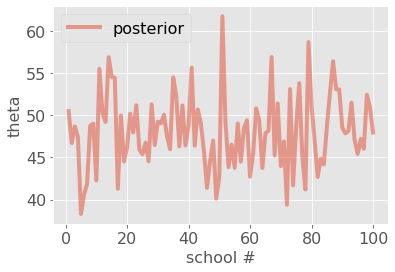

In [60]:
group = df.groupby('group')
plt.plot(np.unique(df['group']),gibbs.traces['theta'].mean(axis=0),alpha=.5, label='posterior')
plt.legend()
plt.xlabel('school #', fontsize=16)
plt.ylabel('theta', fontsize=16);

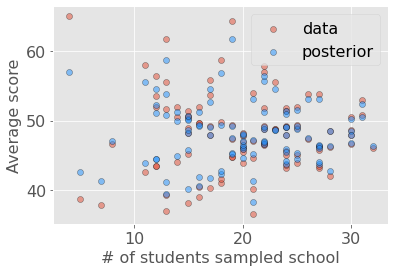

In [61]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='data');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

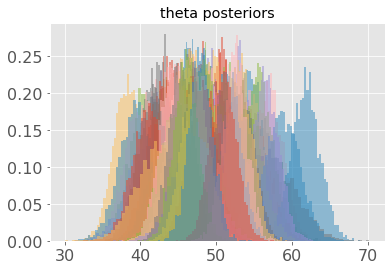

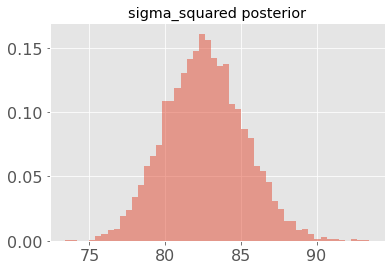

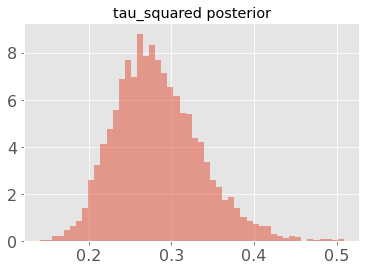

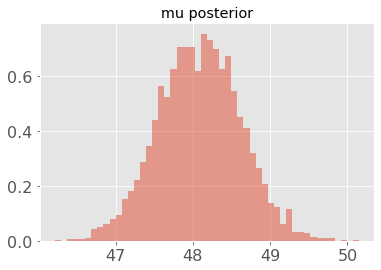

<Figure size 432x288 with 0 Axes>

In [62]:
gibbs.plot_all_posteriors();

In [63]:
post_mean = gibbs.traces['mu'][:, None]
y_i_mean = group.mean().to_numpy().flatten()
ki = (1/gibbs.n_i)/(gibbs.traces['tau_squared'][:, None]*np.ones(gibbs.P) + 1/gibbs.n_i).mean(axis=0)

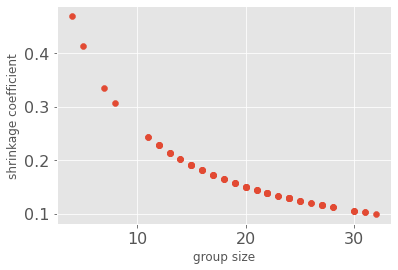

In [64]:
plt.scatter(group.size(), ki)
plt.xlabel('group size')
plt.ylabel('shrinkage coefficient');

In [65]:
number_of_traces = len(gibbs.traces['sigma_squared'])
number_of_schools = 100
simulated_y = np.zeros((number_of_schools, number_of_traces))

for trace in range(number_of_traces):
    simulated_y[:,trace] = norm(loc = gibbs.traces['theta'][trace, :], scale=np.sqrt(gibbs.traces['sigma_squared'][trace])).rvs()
   

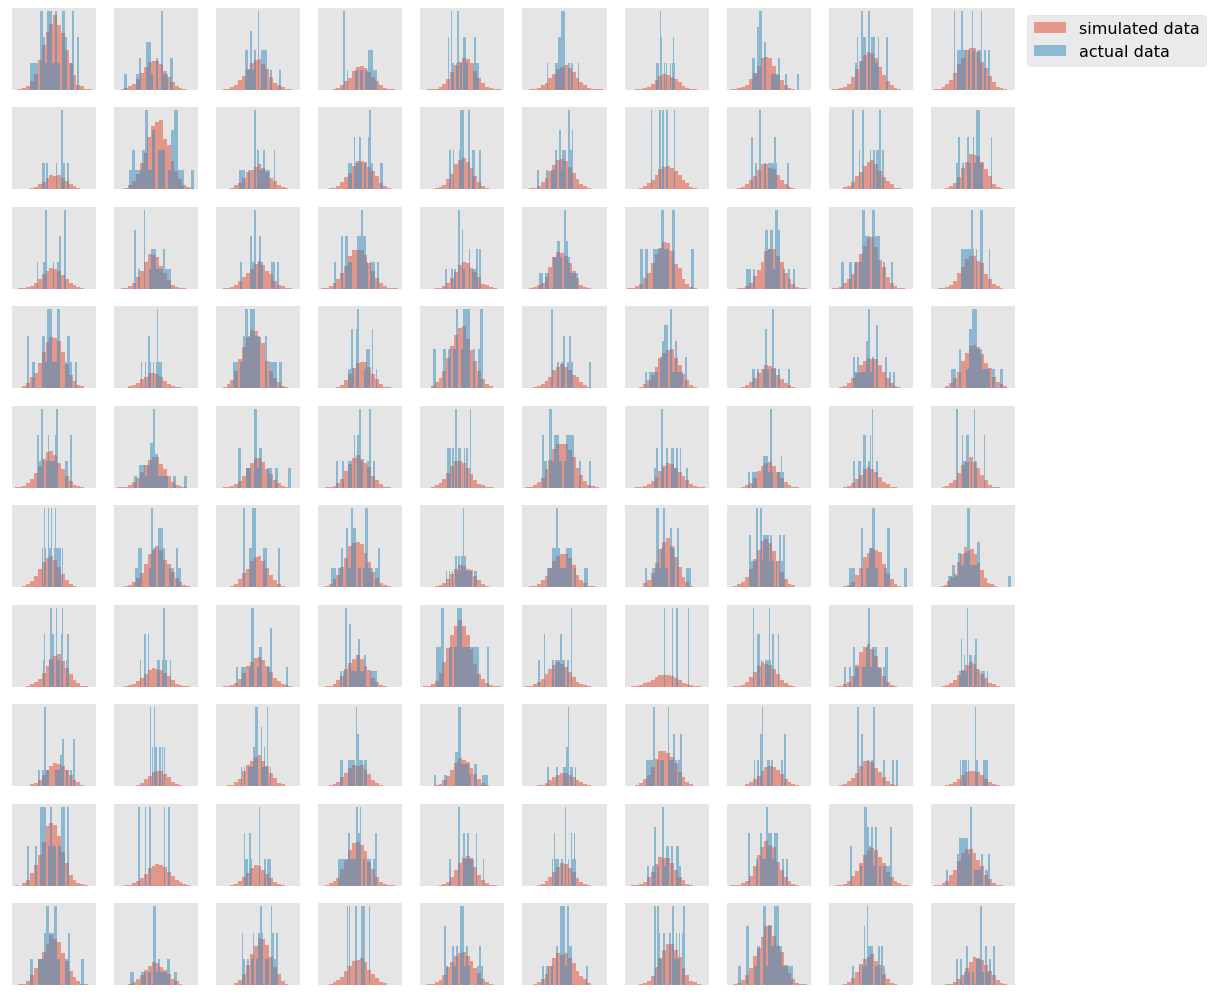

In [66]:
plt.rcParams['figure.figsize'] = 18, 18

for i in range(100):
    plt.subplot(10,10, i+1)
    plt.hist(simulated_y[i,:], density=True, alpha=.5, bins=20, label=f'simulated data')
    plt.hist(df[df['group'] == i+1]['values'], alpha=.5, bins=20, density=True, label=f'actual data')
    plt.xticks([])
    plt.yticks([])
    if i == 9:
        plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('sim_data.png', dpi=500, bbox_inches='tight')

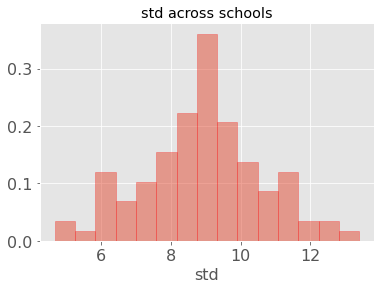

In [24]:
plt.rcParams['figure.figsize'] = 6, 4
plt.hist(group.std(ddof=1), alpha=0.5, edgecolor='red', bins=15, density=True);
plt.title('std across schools');
plt.xlabel('std', fontsize=16);

### try with pymc

In [ ]:
theta_means = []
from tqdm import tqdm
for school in tqdm(range(gibbs.P)):
    data = df[df['group'] == school+1]
    traces = {'sigma': np.zeros(2000),
                       'tau': np.zeros(2000),
                       'mu': np.zeros(2000),
                       'theta': np.zeros(2000)}
    
    with pm.Model() as model:
        sigma = pm.Normal('sigma',mu=1e-6, sigma=1e3)
        mu = pm.Normal('mu',mu=1e-6, sigma=1e3)
        tau = pm.InverseGamma('tau',0.5,0.5)
        theta = pm.Normal('theta', mu=mu, sd = tau*sigma)
        y = pm.Normal('y', mu=theta, sd=sigma, observed=data['values'])
        try:
            trace = pm.sample(2000, tune = 1000, chains=2,cores=1, return_inferencedata=False)
            theta_means.append(trace.get_values('theta').mean())
        except:
             theta_means.append(None)
             


In [ ]:
gibbs_means = gibbs.traces['theta'].mean(axis=0)
plt.scatter(theta_means, gibbs_means)

In [ ]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='prior');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.scatter(group.size(), theta_means, color='green', alpha=.5, edgecolor='black', label='posterior');

plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

In [ ]:
df.groupby('group').size()

In [ ]:
df

In [ ]:
df.groupby('group').size()